# MBTA Data Science Project
Data was retrieved from https://mbta-massdot.opendata.arcgis.com/datasets/mbta-gated-station-entries-historical/about

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

# Import metrics, general model imports
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Note that we use regression for our models since the outcome is continuous

# K-Nearest Neighbors imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

# Random Forest imports
from sklearn.ensemble import RandomForestRegressor

# Support Vector Machine imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR


In [2]:
# Import and compile data
cols = [0, 1, 3, 4, 5]
# We remove the second column due to it representing redundant data
# It represents the stop_id, whose information is also represented by station_name
df = pd.read_csv("GSE_2022.csv", usecols=cols)
df = df[df['route_or_line']=='Green Line'].copy().reset_index(drop=True)
df.head()

,service_date,time_period,station_name,route_or_line,gated_entries
0,2022-12-31,(00:00:00),Government Center,Green Line,1.8
1,2022-12-31,(00:30:00),Government Center,Green Line,9.0
2,2022-12-31,(01:00:00),Arlington,Green Line,2.0
3,2022-12-31,(01:00:00),Copley,Green Line,17.0
4,2022-12-31,(01:00:00),Government Center,Green Line,1.8


## On column redundancy
We see that the column stop_id in the dataset is redundant with the column station_name. Both of these columns indicate the same thing, the stop at which the target entry was allowed, however, the former is much less comprehensible than the latter is. Furthermore, many stops do not have stop_ids, thus making it more difficult to use stop_id to reference stops. As a result, we decided it would be best for the column to be removed entirely, as it was not providing additional information to the dataset. 

## Data Cleaning
Our remaining columns are the incorrect type. We can fix this by first checking for any null data, then setting the types as follows:
- service_data as a datetime
- time_period as a datetime
- station_name as a string
- route_or_line as a string
- gated_entries as a float

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202999 entries, 0 to 202998
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   service_date   202999 non-null  object 
 1   time_period    202999 non-null  object 
 2   station_name   202999 non-null  object 
 3   route_or_line  202999 non-null  object 
 4   gated_entries  202999 non-null  float64
dtypes: float64(1), object(4)
memory usage: 7.7+ MB


In [4]:
# Check for null data
df.isnull().sum()

service_date     0
time_period      0
station_name     0
route_or_line    0
gated_entries    0
dtype: int64

In [5]:
# Setting correct types for columns
df['service_date'] = pd.to_datetime(df['service_date'])
df['time_period'] = pd.to_datetime(df['time_period'], format='(%H:%M:%S)')
df['station_name'] = df['station_name'].astype('string')
df['route_or_line'] = df['route_or_line'].astype('string')
df['gated_entries'] = df['gated_entries'].astype('float')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202999 entries, 0 to 202998
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   service_date   202999 non-null  datetime64[ns]
 1   time_period    202999 non-null  datetime64[ns]
 2   station_name   202999 non-null  string        
 3   route_or_line  202999 non-null  string        
 4   gated_entries  202999 non-null  float64       
dtypes: datetime64[ns](2), float64(1), string(2)
memory usage: 7.7 MB


### Data setup for our algorithms

In [6]:
# Feature engineering using components from datetime features
df['year'] = df['service_date'].dt.year
df['month'] = df['service_date'].dt.month
df['day'] = df['service_date'].dt.day
df['hour'] = df['time_period'].dt.hour
df['minute'] = df['time_period'].dt.minute

# Dropping the original datetime columns
df = df.drop(columns=['service_date', 'time_period'])

# Extract features and target variable
X = df.drop(columns=['gated_entries'])
y = df['gated_entries']

In [7]:
categorical_features = ['station_name', 'route_or_line']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]))
column_names = encoder.get_feature_names_out(categorical_features)
X_encoded.columns = column_names
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

## k-nearest neighbors

In [9]:
# Build the k-nn model, experiment with different values of k and return the best results
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
params = {'n_neighbors': np.arange(1, 5)}
knn_grid = GridSearchCV(estimator = knn, param_grid = params, n_jobs=4, cv=3, return_train_score = True) 
knn_grid.fit(X_train, y_train)
print(knn_grid.best_params_)
print(knn_grid.best_score_)

cv_results = pd.DataFrame(knn_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

{'n_neighbors': 3}
0.6808305258596632


,mean_train_score,std_train_score,mean_test_score,std_test_score
2,0.847092,0.003976,0.680831,0.010525
3,0.823650,0.003438,0.677489,0.009258
1,0.875526,0.004733,0.654598,0.009578
0,1.000000,0.000000,0.511954,0.028249


In [10]:
# Evaluate the model
knn = KNeighborsRegressor(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'The predicted average of gated fares is: {mean(y_pred)}')
mse = mean_squared_error(y_test, y_pred)
print(f'The mean squared error is: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'The r^2 value is: {r2}')

The predicted average of gated fares is: 70.6846722495895
The mean squared error is: 1985.8668629378762
The r^2 value is: 0.7233300984537628


In [11]:
print('As the value of k increased the overall accuracy of the model increased.')
print('When k=3, the model produced the highest accuracy on the test set at 68%.')
print('However, this model is incredibly inefficient with data sets of our size, and as such we will not be proceeding with it.')

As the value of k increased the overall accuracy of the model increased.
When k=3, the model produced the highest accuracy on the test set at 68%.
However, this model is incredibly inefficient with data sets of our size, and as such we will not be proceeding with it.


## Random forest

In [12]:
# Build the rf model, experiment with different values of k and return the best results
rf = RandomForestRegressor()
params = {'n_estimators': np.arange(1, 7)}
rf_grid = GridSearchCV(estimator=rf, param_grid=params, n_jobs=4, cv=3, return_train_score = True) 
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print(rf_grid.best_score_)

cv_results = pd.DataFrame(rf_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

{'n_estimators': 6}
0.7266699146779455


,mean_train_score,std_train_score,mean_test_score,std_test_score
5,0.945387,0.002221,0.726670,0.006566
3,0.934155,0.001596,0.724098,0.002782
4,0.942395,0.001657,0.719715,0.008327
2,0.922750,0.000666,0.701399,0.005732
1,0.898334,0.004442,0.660475,0.014263


In [13]:
# Evaluate the model
rf = RandomForestRegressor(n_estimators = 6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'The predicted average of gated fares is: {mean(y_pred)}')
mse = mean_squared_error(y_test, y_pred)
print(f'The mean squared error is: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'The r^2 value is: {r2}')

The predicted average of gated fares is: 70.55700890804597
The mean squared error is: 1786.5628808302547
The r^2 value is: 0.7510970218747585


In [14]:
print('As the value of n_estimators increased the overall accuracy of the model increased.')
print('When n_estimators=6, the model produced the highest accuracy on the test set at 73%.')
print('This is better than the other results, and as such we will be proceeding with this model.')

As the value of n_estimators increased the overall accuracy of the model increased.
When n_estimators=6, the model produced the highest accuracy on the test set at 73%.
This is better than the other results, and as such we will be proceeding with this model.


## Support vector machine

In [15]:
svm = SVR()
params = {'C': np.arange(1, 3),
         'kernel': ['linear']}
svm_grid = GridSearchCV(estimator=svm, param_grid=params, n_jobs=4, cv=3, return_train_score=True) 
svm_grid.fit(X_train, y_train)
print(svm_grid.best_params_)
print(svm_grid.best_score_)

cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

{'C': 2, 'kernel': 'linear'}
0.2940778956733311


,mean_train_score,std_train_score,mean_test_score,std_test_score
1,0.293993,0.003507,0.294078,0.006898
0,0.293367,0.003482,0.293451,0.006900


In [16]:
# Evaluate the model
svm = SVR(C = 2)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(f'The predicted average of gated fares is: {mean(y_pred)}')
mse = mean_squared_error(y_test, y_pred)
print(f'The mean squared error is: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'The r^2 value is: {r2}')

The predicted average of gated fares is: 43.41780836469611
The mean squared error is: 7770.793245048098
The r^2 value is: -0.08262272872764997


In [17]:
print('As the value of C increased the overall accuracy of the model increased.')
print('When C=2, the model had the worst accuracy out of the three at 29%.')
print('Furthermore, training these parameters took the most time, and are therefore harder to replicate.')
print('This is much worse than the other two, and as such we will not be proceeding with this model.')

As the value of C increased the overall accuracy of the model increased.
When C=2, the model had the worst accuracy out of the three at 29%.
Furthermore, training these parameters took the most time, and are therefore harder to replicate.
This is much worse than the other two, and as such we will not be proceeding with this model.


Overall, we choose the **Random Forest Regression** model for our project due to its higher accuracy, higher r^2 and lower mean squared error compared to the other models when they were run in the same amount of time.

## Random forest visualizations

month     0.140541
day       0.169972
hour      0.325342
minute    0.023016
dtype: float64


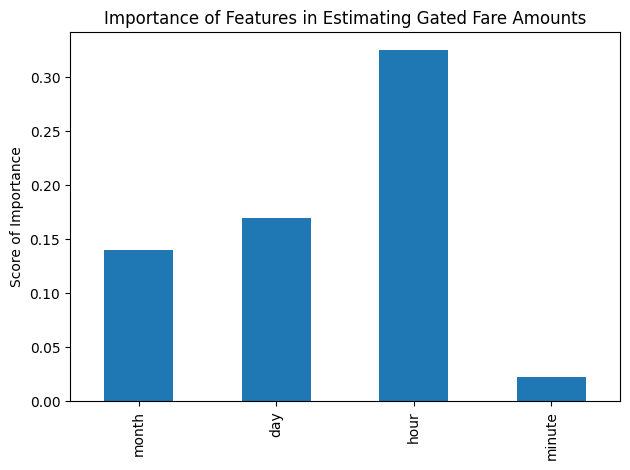

In [18]:
# Graph importance of temporal features in estimating gated fare amounts
fi = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
feature_names = X.columns
forest_importances = pd.Series(fi, index=feature_names)
feature_vals = ['month', 'day', 'hour', 'minute']
test = forest_importances.loc[feature_vals]
print(test)
fig, ax = plt.subplots()
test.plot.bar(ax=ax)
ax.set_title("Importance of Features in Estimating Gated Fare Amounts")
ax.set_ylabel("Score of Importance")
fig.tight_layout()